In [281]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import os
import glob
import numpy as  np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

def get_files(fn):
    home = os.path.expanduser('~')
    path = f'{home}/Downloads/project_mining_2022/dataset/'
    files = glob.glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]

# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if os.stat(f).st_size != 0:
            # create df
            temp = pd.read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = pd.concat(list_of_pandas, ignore_index=True)
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

In [282]:
# list files
# demand_files = get_files('demand')
source_files = get_files('sources')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in source_files]

# get data from files
# demands = parse_file(demand_files, filenames)
sources = parse_file(source_files, filenames)

In [283]:
# move values and drop temp cols
sources['Natural gas'].fillna(sources['Natural Gas'], inplace=True)
sources['Large hydro'].fillna(sources['Large Hydro'], inplace=True)
sources.drop(columns=['Natural Gas', 'Large Hydro'], inplace=True)

# null values in demands are probably due to power cut
# so, linear interpolation will be good estimate
# demands.interpolate(method='linear', axis=0, inplace=True)

# Linear interpolatio for missing data
sources.interpolate(method='linear', axis=0, inplace=True)

In [284]:
sources.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other
2019-01-01 00:00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0
2019-01-01 00:05:00,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0
2019-01-01 00:10:00,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0
2019-01-01 00:15:00,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0
2019-01-01 00:20:00,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0


In [285]:
df = pd.concat([sources[renewable], sources[non_renewable].sum(axis=1)], axis=1)
df.rename(columns = {0:'non_re_sum'}, inplace = True)
df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Large hydro,Batteries,Imports,non_re_sum
2019-01-01 00:00:00,0.0,2810.0,993.0,380.0,225.0,200.0,1924.0,6.0,6254.0,9610.0
2019-01-01 00:05:00,0.0,2862.0,993.0,381.0,226.0,201.0,1866.0,65.0,6266.0,9484.0
2019-01-01 00:10:00,0.0,2916.0,993.0,380.0,226.0,202.0,1849.0,64.0,6319.0,9340.0
2019-01-01 00:15:00,0.0,2920.0,993.0,378.0,223.0,203.0,1827.0,25.0,6354.0,9290.0
2019-01-01 00:20:00,0.0,2902.0,993.0,379.0,223.0,203.0,1840.0,32.0,6360.0,9254.0


In [286]:
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)

day = 60*60*24
year = 365.2425*day

df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Large hydro,Batteries,Imports,non_re_sum,Seconds,Day sin,Day cos,Year sin,Year cos
2019-01-01 00:00:00,0.0,2810.0,993.0,380.0,225.0,200.0,1924.0,6.0,6254.0,9610.0,1.546301e+09,-5.030095e-12,1.000000,0.002021,0.999998
2019-01-01 00:05:00,0.0,2862.0,993.0,381.0,226.0,201.0,1866.0,65.0,6266.0,9484.0,1.546301e+09,2.181489e-02,0.999762,0.002081,0.999998
2019-01-01 00:10:00,0.0,2916.0,993.0,380.0,226.0,202.0,1849.0,64.0,6319.0,9340.0,1.546301e+09,4.361939e-02,0.999048,0.002141,0.999998
2019-01-01 00:15:00,0.0,2920.0,993.0,378.0,223.0,203.0,1827.0,25.0,6354.0,9290.0,1.546302e+09,6.540313e-02,0.997859,0.002201,0.999998
2019-01-01 00:20:00,0.0,2902.0,993.0,379.0,223.0,203.0,1840.0,32.0,6360.0,9254.0,1.546302e+09,8.715574e-02,0.996195,0.002260,0.999997


In [287]:
df = df.drop('Seconds', axis=1)
df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Large hydro,Batteries,Imports,non_re_sum,Day sin,Day cos,Year sin,Year cos
2019-01-01 00:00:00,0.0,2810.0,993.0,380.0,225.0,200.0,1924.0,6.0,6254.0,9610.0,-5.030095e-12,1.000000,0.002021,0.999998
2019-01-01 00:05:00,0.0,2862.0,993.0,381.0,226.0,201.0,1866.0,65.0,6266.0,9484.0,2.181489e-02,0.999762,0.002081,0.999998
2019-01-01 00:10:00,0.0,2916.0,993.0,380.0,226.0,202.0,1849.0,64.0,6319.0,9340.0,4.361939e-02,0.999048,0.002141,0.999998
2019-01-01 00:15:00,0.0,2920.0,993.0,378.0,223.0,203.0,1827.0,25.0,6354.0,9290.0,6.540313e-02,0.997859,0.002201,0.999998
2019-01-01 00:20:00,0.0,2902.0,993.0,379.0,223.0,203.0,1840.0,32.0,6360.0,9254.0,8.715574e-02,0.996195,0.002260,0.999997


In [288]:
def df_to_tensor(df, window_size=12):
    data = df.to_numpy()
    X, y = [], []
    for i in range(data.shape[0]-window_size):
        row = [r for r in data[i:i+window_size]]
        label = data[i+window_size][9]
        X.append(row)
        y.append(label)
    return np.array(X), np.array(y)

In [289]:
WINDOW_SIZE = 12
X, y = df_to_tensor(df, WINDOW_SIZE)
print(X[0])

[[ 0.00000000e+00  2.81000000e+03  9.93000000e+02  3.80000000e+02
   2.25000000e+02  2.00000000e+02  1.92400000e+03  6.00000000e+00
   6.25400000e+03  9.61000000e+03 -5.03009464e-12  1.00000000e+00
   2.02132493e-03  9.99997957e-01]
 [ 0.00000000e+00  2.86200000e+03  9.93000000e+02  3.81000000e+02
   2.26000000e+02  2.01000000e+02  1.86600000e+03  6.50000000e+01
   6.26600000e+03  9.48400000e+03  2.18148850e-02  9.99762027e-01
   2.08105667e-03  9.99997835e-01]
 [ 0.00000000e+00  2.91600000e+03  9.93000000e+02  3.80000000e+02
   2.26000000e+02  2.02000000e+02  1.84900000e+03  6.40000000e+01
   6.31900000e+03  9.34000000e+03  4.36193874e-02  9.99048222e-01
   2.14078840e-03  9.99997709e-01]
 [ 0.00000000e+00  2.92000000e+03  9.93000000e+02  3.78000000e+02
   2.23000000e+02  2.03000000e+02  1.82700000e+03  2.50000000e+01
   6.35400000e+03  9.29000000e+03  6.54031292e-02  9.97858923e-01
   2.20052013e-03  9.99997579e-01]
 [ 0.00000000e+00  2.90200000e+03  9.93000000e+02  3.79000000e+02
  

In [290]:
print(y[:2])

[9092. 9072.]


In [291]:
X.shape, y.shape

((315636, 12, 14), (315636,))

In [292]:
# 2 full years per hour data
X_train, y_train = X[:210527], y[:210527]
X_test, y_test = X[210527:], y[210527:]
# X_val, y_val = X[290000:], y[290000:]

In [293]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((210527, 12, 14), (210527,), (105109, 12, 14), (105109,))

In [294]:
means, stds = [], []
for i in range(X_train.shape[2]-4):
    means.append(np.mean(X_train[:, :, i]))
    stds.append(np.std(X_train[:, :, i]))
    
print(means)
print(stds)

def preprocess_input(X, mean, std):
    for i in range(X.shape[2]-4):
        X[:, :, i] = (X[:, :, i] - mean[i]) / std[i]
    return X

def preprocess_output(y, mean, std):
    y[:] = (y[:] - mean) / std
    return y

[3378.3171730941876, 1883.3530901024571, 880.8901684819524, 319.60763029603487, 213.8727083303646, 311.81962764871014, 2282.6600202507675, -2.697052713745347, 6164.9522860092375, 9790.10272316615]
[4150.820082453391, 1245.504565397382, 127.85944608854632, 49.53910708892827, 16.032076106081437, 948.3674689862885, 1301.1706658740063, 34.34200835380716, 2493.2905265870154, 3933.549262050329]


In [295]:
X_train_scaled = preprocess_input(X_train, means, stds)
X_test_scaled = preprocess_input(X_test, means, stds)
print(X_train_scaled[0, 0, :])
print(X_test_scaled[0, 0, :])

[-8.13891498e-01  7.43993186e-01  8.76820876e-01  1.21908474e+00
  6.94064299e-01 -1.17907490e-01 -2.75644102e-01  2.53248227e-01
  3.57149370e-02 -4.57863144e-02 -5.03009464e-12  1.00000000e+00
  2.02132493e-03  9.99997957e-01]
[-0.82376906 -0.38566947  0.5952617  -0.21412639 -0.92768449 -0.17801077
 -1.22171523 -1.93066598  1.42143391 -0.14823832 -0.02181489  0.99976203
  0.01082081  0.99994145]


In [296]:
y_train_scaled = preprocess_output(y_train, means[-1], stds[-1])
y_test_scaled = preprocess_output(y_test, means[-1], stds[-1])
print(y_train_scaled)
print(y_test_scaled)

[-0.177474   -0.18255847 -0.17899934 ... -0.24535163 -0.25628323
 -0.27560421]
[-0.29339984 -0.30153499 -0.30204343 ... -0.07197132 -0.06790374
 -0.06815797]


In [297]:
model = Sequential()
model.add(InputLayer((X.shape[1], X.shape[2])))
model.add(LSTM(128))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))
# kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               73216     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 81,537
Trainable params: 81,537
Non-trainable params: 0
_________________________________________________________________


In [298]:
cp = ModelCheckpoint('model/', save_best_only=True)
es = EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [299]:
history = model.fit(X_train_scaled, y_train_scaled, validation_split=0.33, epochs=20, callbacks=[cp, es], shuffle=False)

Epoch 1/20
4407/4408 [============================>.] - ETA: 0s - loss: 0.0837 - root_mean_squared_error: 0.2893

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4408/4408 [==============================] - 101s 23ms/step - loss: 0.0837 - root_mean_squared_error: 0.2893 - val_loss: 0.0496 - val_root_mean_squared_error: 0.2226
Epoch 2/20
4405/4408 [============================>.] - ETA: 0s - loss: 0.0654 - root_mean_squared_error: 0.2557

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4408/4408 [==============================] - 96s 22ms/step - loss: 0.0653 - root_mean_squared_error: 0.2556 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1434
Epoch 3/20
4408/4408 [==============================] - ETA: 0s - loss: 0.0615 - root_mean_squared_error: 0.2479

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4408/4408 [==============================] - 85s 19ms/step - loss: 0.0615 - root_mean_squared_error: 0.2479 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 4/20
4408/4408 [==============================] - 94s 21ms/step - loss: 0.0587 - root_mean_squared_error: 0.2423 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 5/20
4408/4408 [==============================] - 98s 22ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369
Epoch 6/20
4408/4408 [==============================] - 96s 22ms/step - loss: 0.0543 - root_mean_squared_error: 0.2330 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 7/20
4408/4408 [==============================] - ETA: 0s - loss: 0.0520 - root_mean_squared_error: 0.2280

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4408/4408 [==============================] - 101s 23ms/step - loss: 0.0520 - root_mean_squared_error: 0.2280 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 8/20
4408/4408 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2245

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4408/4408 [==============================] - 107s 24ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0745
Epoch 9/20
4408/4408 [==============================] - 119s 27ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 10/20
4408/4408 [==============================] - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.2084

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


4408/4408 [==============================] - 103s 23ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 11/20
4408/4408 [==============================] - 102s 23ms/step - loss: 0.0414 - root_mean_squared_error: 0.2034 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 12/20
4408/4408 [==============================] - 102s 23ms/step - loss: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 13/20
4408/4408 [==============================] - 107s 24ms/step - loss: 0.0397 - root_mean_squared_error: 0.1993 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 14/20
4408/4408 [==============================] - 98s 22ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 15/20
4408/4408 [==============================] - 115s 26ms/step - loss: 0.0410 - root_mean_squared_error: 0.2024 - 

In [300]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [301]:
def plot(history):
    # summarize history for loss
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    losses = [('loss', 'val_loss'), ('root_mean_squared_error', 'val_root_mean_squared_error')]
    for i in range(2):
        ax[i].plot(history.history[losses[i][0]])
        ax[i].plot(history.history[losses[i][1]])
        ax[i].set_title('Loss - '+losses[i][0])
        ax[i].set_ylabel('loss')
        ax[i].set_xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

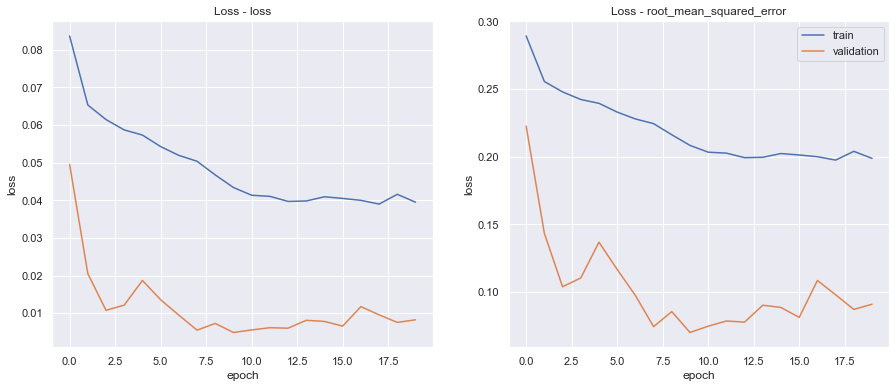

In [302]:
plot(history)

In [303]:
train_predictions = model.predict(X_train_scaled).flatten()
X_original = (train_predictions*means[-1]) + stds[-1]
y_original = (y_train * means[-1]) + stds[-1]
train_results = pd.DataFrame(data={'Train Predictions':X_original, 'Actuals':y_original})
train_results

6579/6579 [==============================] - 42s 6ms/step


,Train Predictions,Actuals
0,2000.283813,2196.060568
1,2266.910156,2146.283117
2,2180.592773,2181.127333
3,2161.048340,2166.194097
4,2210.660156,2101.483411
...,...,...
210522,2084.960449,1944.684442
210523,1845.229980,1698.286061
210524,1487.863770,1531.531601
210525,1379.114502,1424.510082


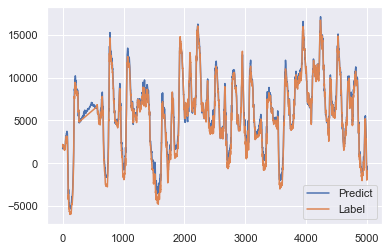

In [315]:
plt.plot(original_train_results['Train Predictions'][:5000], label='Predict')
plt.plot(original_train_results['Actuals'][:5000], label='Label')
plt.legend()
plt.show()

In [316]:
test_predictions = model.predict(X_test_scaled).flatten()
X_original_test = (test_predictions*means[-1]) + stds[-1]
y_original_test = (y_test * means[-1]) + stds[-1]
test_results = pd.DataFrame(data={'Test Predictions':X_original_test, 'Actuals':y_original_test})
test_results

3285/3285 [==============================] - 23s 7ms/step


,Test Predictions,Actuals
0,1145.782227,1061.134692
1,988.545410,981.490771
2,968.621338,976.513026
3,1016.945068,951.624300
4,982.032715,819.714056
...,...,...
105104,3529.370850,3388.230512
105105,3465.272949,3286.186738
105106,3217.234863,3228.942670
105107,3065.325684,3268.764630


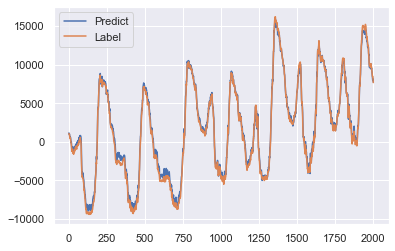

In [317]:
plt.plot(test_results['Test Predictions'][:2000], label='Predict')
plt.plot(test_results['Actuals'][:2000], label='Label')
plt.legend()
plt.show()